In [1]:
import requests
import json
import shutil


class ApiCrawler(object):
    def __init__(self):
        self.crawled_apps = []
        self.crawled_data = {}
        self.to_crawl_list = []
        self.chart_types = ['top-free', 'top-grossing', 'top-paid']

    def create_crawl_list_from_rss(self):
        for chart_type in self.chart_types:
            url = 'https://rss.itunes.apple.com/api/v1/us/ios-apps/%s/all/200/explicit.json' % chart_type
            chart_json = self.download_json_from_url(url, 'chart')
            if chart_json:
                app_ids = self.app_ids_from_chart(chart_json)
                self.to_crawl_list.extend(app_ids)

    @staticmethod
    def app_ids_from_chart(chart_json):
        app_ids = []
        for app in chart_json:
            app_ids.append(app['id'])
        return app_ids

    def crawl(self):
        self.to_crawl_list = list(set(self.to_crawl_list))
        while self.to_crawl_list:
            app_id = self.to_crawl_list.pop(0)
            url = 'https://itunes.apple.com/lookup?id=%s' % app_id
            try:
                self.crawled_data[app_id] = self.download_json_from_url(url, 'app')
                self.crawled_apps.append(app_id)
            except:
                print('Something went wrong with %s.' % app_id)

    def download_icons(self):
        for app_id, data in self.crawled_data.items():
            try:
                icon100_url = data['artworkUrl100']
                self.download_image(app_id, icon100_url, 'jpg')
            except:
                print('Failed to find the icon for app_id: ' + app_id)

    @staticmethod
    def download_image(app_id, url, file_type):
        r = requests.get(url, stream=True)
        if r.status_code == 200:
            with open('icons/' + app_id + '.' + file_type, 'wb') as f:
                r.raw.decode_content = True
                shutil.copyfileobj(r.raw, f)

    @staticmethod
    def download_json_from_url(url, type):
        data = None
        u = requests.get(url)
        # u.raise_for_status()
        page = u.json()
        try:
            if type == 'app':
                data = page['results'][0]
            elif type == 'chart':
                data = page['feed']['results']
        except:
            pass
        return data

    def save_data_as_json(self):
        with open('crawled_data.json', 'w') as fp:
            json.dump(self.crawled_data, fp)

    def read_json_as_dict(self):
        with open('crawled_data.json', 'r') as f:
            self.crawled_data = json.load(f)


# c = ApiCrawler()
# c.create_crawl_list_from_rss()
# c.crawl()
# c.save_data_as_json()
# c.read_json_as_dict()
# c.download_icons()

In [10]:
import os
import cv2
import json
import numpy as np

class ImageDataset(object):
    def __init__(self, train_path):
        self.train_path = train_path
        self.image_filenames = os.listdir(train_path)

    def load_image(self, file_path):
        return cv2.imread(file_path)

    def get_image_arrays(self):
        return np.array([self.load_image(self.train_path + filename) for filename in self.image_filenames])

    def read_json_as_dict(self):
        with open('crawled_data.json', 'r') as f:
            return json.load(f)

    def get_image_lables(self):
        labels = []
        label_dataset = self.read_json_as_dict()
        for image_filename in self.image_filenames:
            rating_count = label_dataset[image_filename[:-4]]['userRatingCount']
            labels.append(rating_count)
        return np.array(labels)

In [11]:
imd = ImageDataset('icons/')
images = imd.get_image_arrays()
labels = imd.get_image_lables()

In [12]:
import matplotlib.pyplot as plt

In [13]:
%matplotlib inline

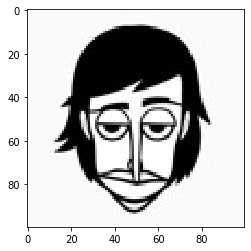

In [14]:
plt.imshow(images[0])

In [21]:
images.shape[1:]

(100, 100, 3)

In [7]:
import tensorflow as tf

In [8]:
tf.__version__

'2.0.0'

In [23]:
layers = [
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same",
                           activation=tf.nn.relu, input_shape=images.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same",
                           activation=tf.nn.relu, input_shape=images.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same",
                           activation=tf.nn.relu, input_shape=images.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same",
                           activation=tf.nn.relu, input_shape=images.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same",
                           activation=tf.nn.relu, input_shape=images.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=256, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)
]

In [24]:
model = tf.keras.Sequential(layers)

In [29]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.001), loss='mse',metrics=['mae', 'mse'])

In [30]:
model.fit(images, labels, epochs=5, batch_size=20)
model.save_weights('model.tf')

Train on 558 samples
Epoch 1/5
558/558 [==============================] - 4s 7ms/sample - loss: 1850859007368.7168 - mae: 557738.0625 - mse: 1850858799104.0000
Epoch 2/5
558/558 [==============================] - 3s 5ms/sample - loss: 1755595019781.5054 - mae: 518350.4062 - mse: 1755594883072.0000
Epoch 3/5
558/558 [==============================] - 3s 5ms/sample - loss: 1767955577353.1755 - mae: 537763.9375 - mse: 1767955628032.0000
Epoch 4/5
558/558 [==============================] - 3s 5ms/sample - loss: 1760229372006.7668 - mae: 518496.4062 - mse: 1760229195776.0000
Epoch 5/5
558/558 [==============================] - 4s 7ms/sample - loss: 1755681833547.2402 - mae: 531063.3125 - mse: 1755681914880.0000


In [33]:
eval_model = tf.keras.Sequential(layers)
eval_model.load_weights('model.tf')

In [39]:
eval_model.predict(images[:10])

array([[279697.88 ],
       [191378.23 ],
       [229928.1  ],
       [232085.58 ],
       [ 96170.375],
       [353921.3  ],
       [367155.1  ],
       [320032.66 ],
       [373595.7  ],
       [209192.44 ]], dtype=float32)

In [38]:
labels[:10]

array([  4064, 133018,    108,   1900, 385433,  61371, 525335, 257897,
          146,   4596])